In [ ]:
import os
import sys
import numpy as np
import sympy as sp
import torch as pt
from torch.nn.functional import normalize
import scipy
from tqdm import tqdm
import random
from sklearn.model_selection import train_test_split
import logging
import sys
from torch.utils.data import TensorDataset, DataLoader
from torch.func import hessian, vmap
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = pt.device("cuda" if pt.cuda.is_available() else "cpu")

sys.path.append(os.path.abspath('../../'))

from src.useful_functions import *
from src.data_modules.PWDs_module import generate_PWDistances_torch
from src.data_modules.sqra_functions import*
from src.data_modules.openmm_functions import*
from src.isokann.isoka import*
# For reproducibility
np.random.seed(0)


# Read directory paths
read_dirs_paths('../dir_paths_.txt', globals())



 
Created variables:
inp_dir = /scratch/htc/fsafarov/structures/8ef5_july_2025/8ef5/
dcd_dir = /scratch/htc/fsafarov/mOR_dcd_files/npat/
out_dir = /scratch/htc/fsafarov/ISOKANN_PINN/output/


In [2]:
forces = pt.load(os.path.join(out_dir, 'mor_forces_component.pt'))
positions = pt.load(os.path.join(out_dir, 'mor_coords.pt'))

In [3]:
print(positions.shape)
print(forces.shape)

torch.Size([5534, 287, 3])
torch.Size([5534, 287, 3])


In [4]:
n_samples = positions.shape[0]
n_particles = positions.shape[-2]

In [5]:
atomic_numbers = pt.ones(( n_samples, n_particles,1)).long()


In [6]:
# import torch_geometric.typing
from torch_geometric.nn.models import SchNet


In [7]:
base_model = SchNet(
            hidden_channels=32,
            num_filters=32,
            num_interactions=2,
            num_gaussians=10,
            cutoff=10.0,
        )

In [8]:
# inp_dim = positions.shape[-1]
# nodes = [inp_dim, 256, 128, 64, 1] 
# base_mlp = MLP(nodes, act_fun='tanh')

In [9]:
# optimizer = pt.optim.Adam([
#     {'params': model.net.parameters(), 'lr': 1e-4},
#     {'params': [model.c1_, model.c2_], 'lr': 1e-3}
# ], weight_decay=1e-5)
# optimizer = pt.optim.SGD([
#     {'params': model.net.parameters(), 'lr': 1e-4},
#     {'params': [model.c1_, model.c2_], 'lr': 1e-3}
# ], weight_decay=1e-5, momentum=0.85, nesterov=True)
# D=2.5         

In [10]:
model = ratesNN(base_model)
optimizer = pt.optim.SGD(model.parameters(), lr=1e-4, weight_decay=1e-5, momentum=0.85, nesterov=True)
           

c1_vals, c2_vals = trainNN(
    model=model, 
    coords=positions.to(device), 
    forces_fn=forces.to(device),
    atomic_numbers=atomic_numbers.to(device), 
    batch_size=500,
    optimizer=optimizer, 
    Nepochs=1000,
    lam_bound=0.1,
    device=device
)

epoch   0 | loss nan |


KeyboardInterrupt: 

In [ ]:
model.c1

tensor(0.6931, device='cuda:0', grad_fn=<SoftplusBackward0>)

In [ ]:
with pt.no_grad():
    chi = model(positions.to(device))


In [ ]:
def scale_and_shift(y):
    minarr = pt.min(y)
    maxarr = pt.max(y)
    hat_y =  (y - minarr) / (maxarr - minarr)

    return hat_y

chi_s = scale_and_shift(chi)
chi_s = chi_s.cpu().detach().numpy()

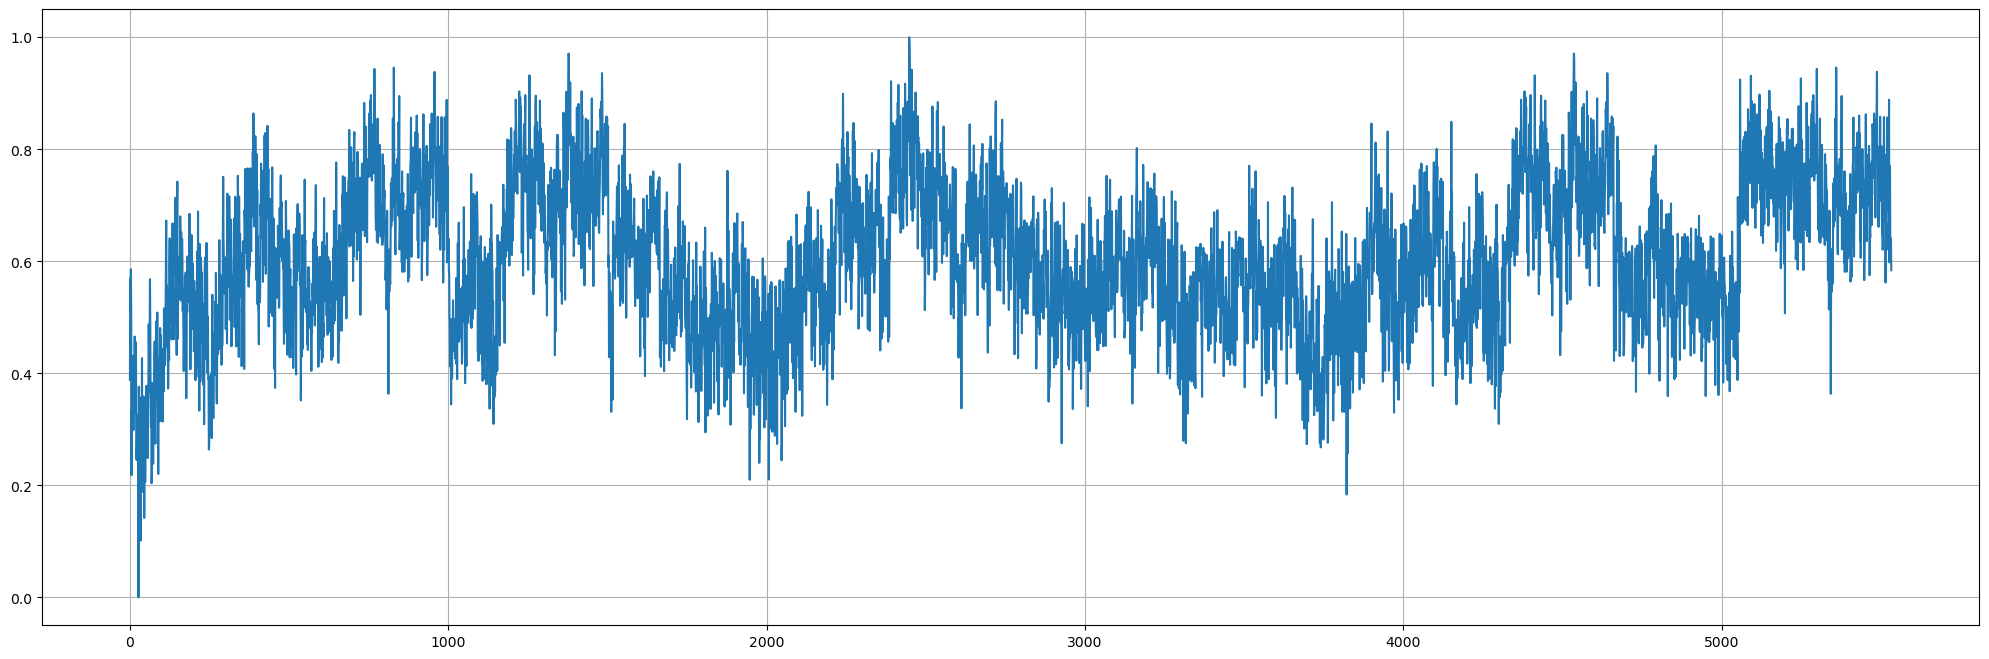

In [ ]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(25,8))
plt.plot(chi_s)
plt.grid()

In [ ]:
np.savetxt(os.path.join(out_dir, 'chi_mor_gnn_ad.txt'), chi_s)

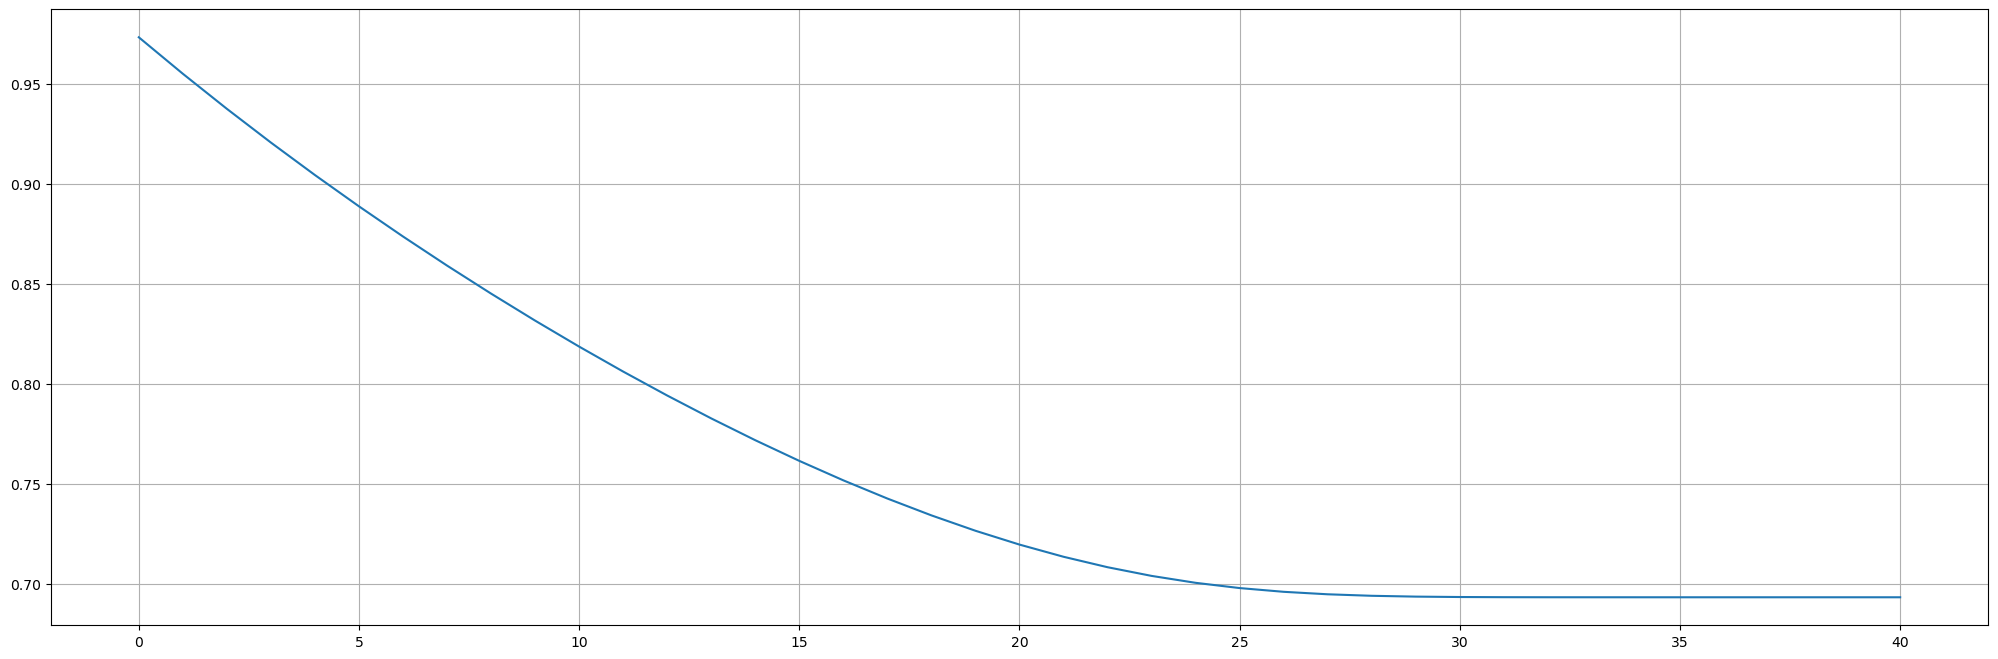

In [ ]:
plt.figure(figsize=(25,8))
plt.plot(c2_vals)
plt.grid()

In [ ]:
del forces
del positions